In [492]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [493]:
# Dados
PETR4SA = 'PETR4.SA'
START_DATE = '2022-01-01'
END_DATE = '2023-01-31'

In [494]:
# Funções

# Accumulation / Distribution Oscillation
def ad_oscillator(closing, low, high, volume):
  return ((closing-low) - (high - closing)) * volume / (high-low)

# Larry William's R%
def larry_william_rperc(closing, low, high):
  if (high - low == 0):
    return -100
  return (high - closing) * (-100) / (high - low)

def momentum(closing, past_closing):
  return closing - past_closing

# Relative Strength Index
def rsi(series):
  temp = np.NaN
  Up = 0
  Down = 0
  n = len(series)
  for x in series:
    if temp == np.NaN:
      temp = x
      if x > 0:
        Up = x
      elif x < 0:
        Down = x
    else:
      if x > temp:
        Up = Up + 1
      elif x < temp:
        Down = Down + 1
      temp = x
  if Down == 0 or n == 0:
    return 100
  return (1-(Up/n)/(Down/n)) and (100 - (100/(1-(Up/n)/(Down/n)))) or 100

# Stochastic K%
def stochastic_k(closing, min, max):
  if (max - min == 0):
    return 0
  return 100 * (closing - min) / (max - min)

# Stochastic D% is the 3-day SMA of K%

# Commodity Channel Index
def cci(typical_price, moving_average, mean_deviation):
  if (mean_deviation == 0):
    return 0
  return (typical_price - moving_average) / (0.015 * mean_deviation)

def min_max_normalize(col):
  return (col - col.min()) / (col.max() - col.min())

In [495]:
# Faça download da série temporal que desejamos estudar
PETR4SA_df = yf.download(PETR4SA,
                 start = START_DATE,
                 end = END_DATE,
                 progress = False)

In [496]:
PETR4SA_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-01-03  28.540001  29.219999  28.530001  29.090000  14.200679  52704700   
2022-01-04  29.160000  29.400000  28.910000  29.200001  14.254376  51739200   
2022-01-05  29.190001  29.270000  27.940001  28.070000  13.702752  78459800   
2022-01-06  28.290001  28.650000  27.840000  28.049999  13.692989  61163100   
2022-01-07  28.110001  28.290001  27.820000  28.180000  13.756451  47507600   
...               ...        ...        ...        ...        ...       ...   
2023-01-24  27.469999  27.530001  26.370001  26.600000  22.219486  65794000   
2023-01-25  26.549999  27.080000  26.010000  26.940001  22.503494  51832900   
2023-01-26  27.090000  27.200001  25.799999  26.250000  21.927124  73344800   
2023-01-27  26.180000  26.230000  25.440001  25.620001  21.400873  47681900   
2023-01-30  25.850000  26.070000  25.510000  25.7500

<Axes: xlabel='Date'>

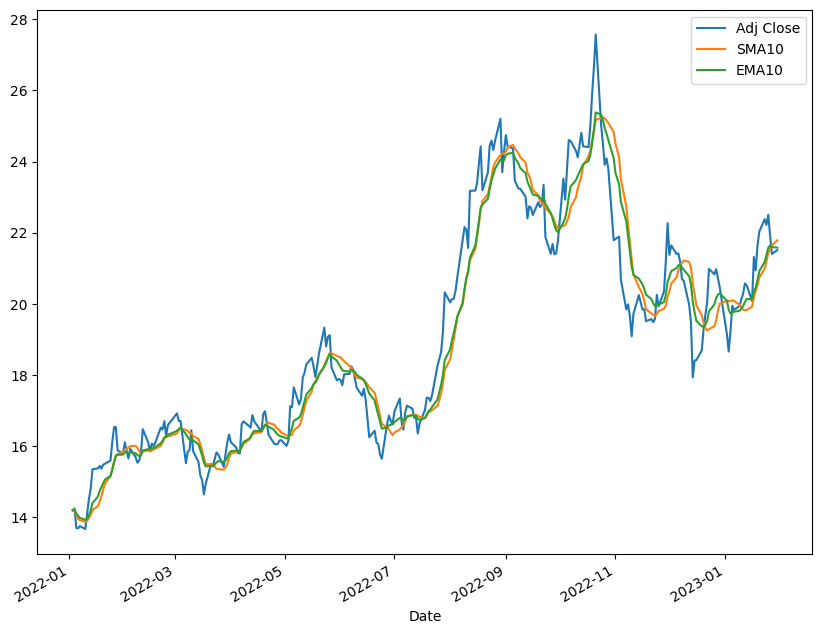

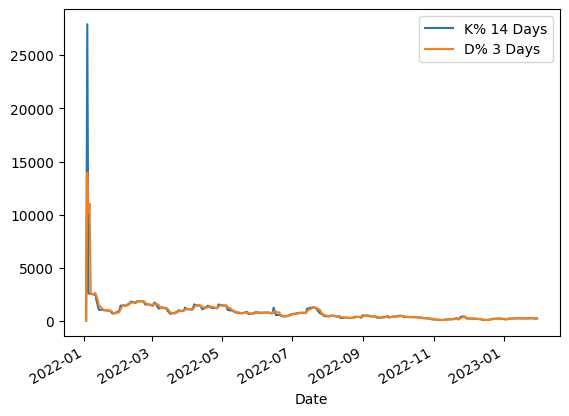

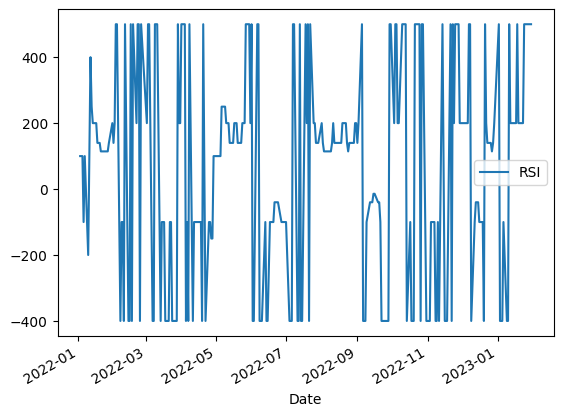

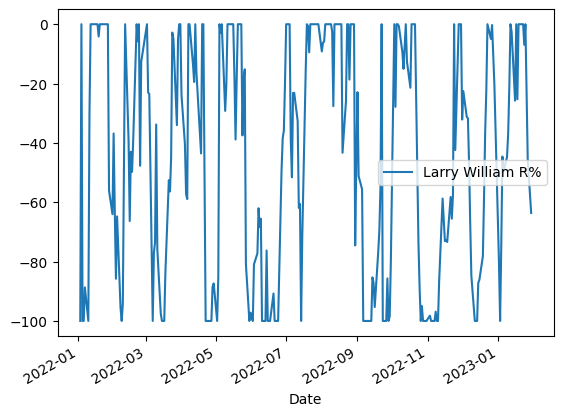

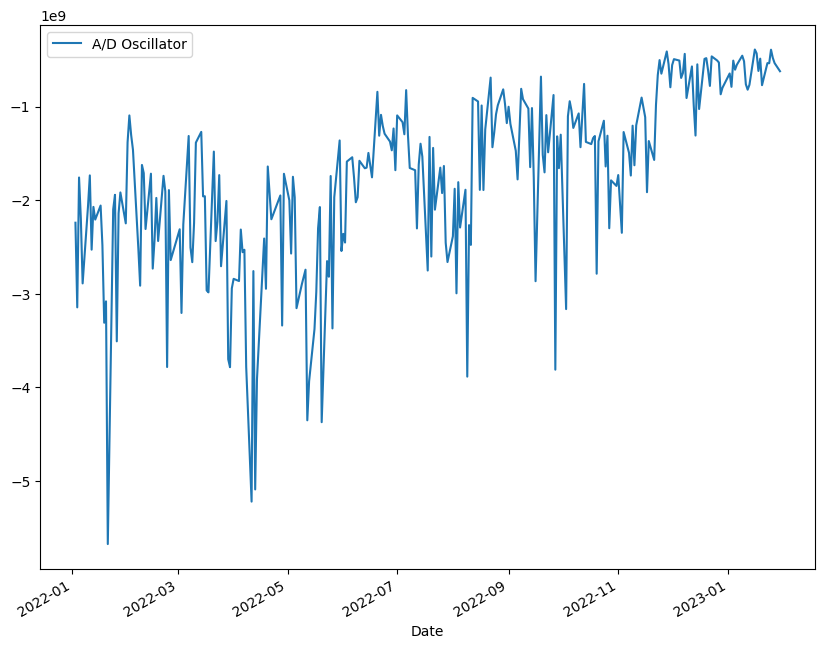

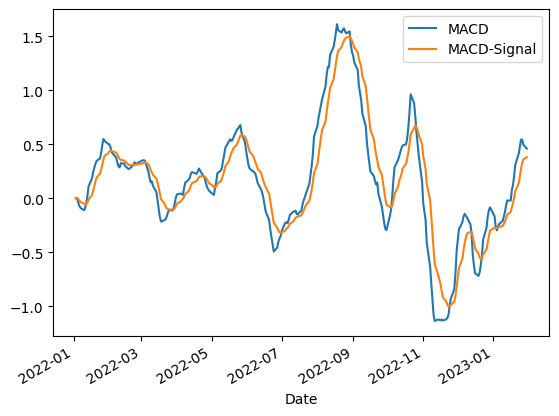

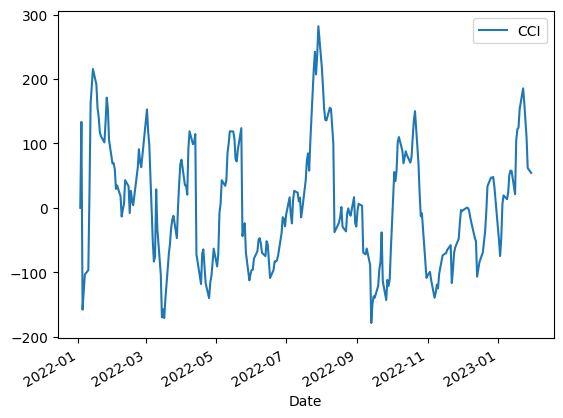

In [497]:
from sklearn import preprocessing

def scale_values(x):
  scaler = preprocessing.MinMaxScaler()
  x_scaled = scaler.fit_transform(x)
  return x_scaled, scaler

def add_metrics(df):
  df['SMA10'] = df['Adj Close'].rolling(10, min_periods=1).mean()
  df['EMA10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
  df['SMA14'] = df['Adj Close'].rolling(14, min_periods=1).mean()
  df['SMA21'] = df['Adj Close'].rolling(21, min_periods=1).mean()
  df['Max10Past'] = df['Adj Close'].rolling(10, min_periods=1).max()
  df['Min10Past'] = df['Adj Close'].rolling(10, min_periods=1).min()
  df['Max14Past'] = df['Adj Close'].rolling(14, min_periods=1).max()
  df['Min14Past'] = df['Adj Close'].rolling(14, min_periods=1).min()
  # Stochasting K% for 14 days
  df['K% 14 Days'] = df.apply(lambda x : stochastic_k(x['Close'], x['Min14Past'], x['Max14Past']), axis=1)
  del df['Max14Past']
  del df['Min14Past']
  # Stochasting D% for 3 days
  df['D% 3 Days'] = df['K% 14 Days'].rolling(3, min_periods=1).mean()
  # A/D Oscillator
  df['A/D Oscillator'] = df.apply(lambda x : ad_oscillator(x['Adj Close'], x['Low'], x['High'], x['Volume']), axis=1)
  # Larry William's R%
  df['Larry William R%'] = df.apply(lambda x : larry_william_rperc(x['Adj Close'], x['Min10Past'], x['Max10Past']), axis=1)
  # Relative Strength Index
  df['RSI'] = df['Adj Close'].rolling(10, min_periods=1).apply(rsi)
  # Moving Average Convergence Divergence for 9 days
  df['EMA12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
  df['EMA26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
  df['MACD'] = df.apply(lambda x: x['EMA12'] - x['EMA26'], axis=1)
  df['MACD-Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
  del df['EMA12']
  del df['EMA26']
  # Commodity Channel Index for 20 days
  df['Typical Price'] = df.apply(lambda x : (x['High'] + x['Close'] + x['Low']) / 3, axis=1)
  df['Typical Price MA'] = df['Typical Price'].rolling(20, min_periods=1).mean()
  df['Deviation'] = df.apply(lambda x : abs(x['Typical Price'] - x['Typical Price MA']), axis=1)
  df['Mean Deviation'] = df['Deviation'].rolling(20, min_periods=1).mean()
  df['CCI'] = df.apply(lambda x : cci(x['Typical Price'], x['Typical Price MA'], x['Mean Deviation']), axis=1)
  del df['Typical Price']
  del df['Typical Price MA']
  del df['Deviation']
  del df['Mean Deviation']
  return df
# Aqui criamos varios indicadores a serem utilizados posteriormente como entrada pela rede neural
PETR4_prices = PETR4SA_df['Adj Close'].values

#PETR4SA_norm = PETR4SA_df.copy(deep=True)


#PETR4SA_norm['High'], scaler = scale_values(PETR4SA_norm['High'].values.reshape(-1,1))
#PETR4SA_norm['Low'], scaler = scale_values(PETR4SA_norm['Low'].values.reshape(-1,1))
#PETR4SA_norm['Close'], scaler = scale_values(PETR4SA_norm['Close'].values.reshape(-1,1))
#PETR4SA_norm['Adj Close'], scaler = scale_values(PETR4SA_norm['Adj Close'].values.reshape(-1,1))

PETR4SA_df = add_metrics(PETR4SA_df)

print(PETR4SA_df)
#print(PETR4SA_norm)

PETR4SA_df[['Adj Close', 'SMA10', 'EMA10']].plot(figsize=(10,8))
PETR4SA_df[['K% 14 Days', 'D% 3 Days']].plot()
PETR4SA_df[['RSI']].plot()
PETR4SA_df[['Larry William R%']].plot()
PETR4SA_df[['A/D Oscillator']].plot(figsize=(10,8))
PETR4SA_df[['MACD', 'MACD-Signal']].plot()
PETR4SA_df[['CCI']].plot()

(array([-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
        -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
        -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
        -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
         -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60]),
 array([0.78790446, 0.79137067, 0.79460393, 0.7979878 , 0.8013209 ,
        0.80445774, 0.80768993, 0.81108374, 0.81434713, 0.81749165,
        0.82064104, 0.82386662, 0.82717435, 0.83052802, 0.83417116,
        0.8376534 , 0.84115799, 0.8448255 , 0.84892622, 0.85282409,
        0.85683705, 0.86080841, 0.8646761

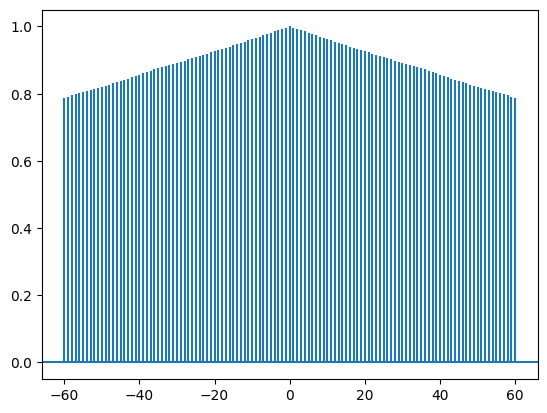

In [498]:
# Plotamos a correlação dos dados com si mesmos para estimarmos quantos dias podemos correlacionar a um valor futuro
plt.xcorr(PETR4_prices, PETR4_prices, maxlags = 60)

In [499]:
df_size = len(PETR4SA_df)
print(df_size)

271


In [500]:
# Dados de treino/validação/teste
VALIDATION_SIZE = 30
TEST_SIZE = 30
BATCH_SIZE = 5

In [501]:
# Esta funcao organizara os indicadores previamente definidos junto do preco de fechamento ajustado para um dado dia N. Queremos prever o dia N+1.
def organize_indicators_ma(df):
  X, y = [], []

  df_pred = df.shift(periods=-1)
  for index, row in df.iterrows():
    X.append([row['Adj Close'], row['SMA10'], row['EMA10'], row['SMA14'], row['SMA21']])
  y = df_pred['Adj Close'].values
  X = X[:-1]
  y = y[:-1]
  return np.array(X), np.array(y)

def organize_indicators_all(df):
  X, y = [], []

  df_pred = df.shift(periods=-1)
  for index, row in df.iterrows():
    X.append([row['Adj Close'], row['SMA10'], row['EMA10'], row['SMA14'], row['SMA21'], row['K% 14 Days'], row['D% 3 Days'], row['A/D Oscillator'], row['Larry William R%'], row['MACD'], row['MACD-Signal'], row['RSI'], row['CCI']])
  y = df_pred['Adj Close'].values
  X = X[:-1]
  y = y[:-1]
  return np.array(X), np.array(y)

def prepare_input_data(series, step_size):
  X, y = [], []
  for step in range(len(series) - step_size):
    end_step = step + step_size
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

In [502]:
X = PETR4SA_df['Adj Close'].values

In [503]:
valid_ind = len(X) - VALIDATION_SIZE - TEST_SIZE
test_ind = len(X) - TEST_SIZE

In [504]:
# ARIMA como benchmark
from statsmodels.tsa.arima.model import ARIMA

train_ARIMA = X[0:valid_ind]
test_ARIMA = X[valid_ind:]
print(len(train_ARIMA))
print(len(test_ARIMA))
series_ARIMA = [x for x in train_ARIMA]
pred_ARIMA = list()
for i in range(len(test_ARIMA)):
  model = ARIMA(series_ARIMA, order=(10,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  y_pred = output[0]
  pred_ARIMA.append(y_pred)
  expected = test_ARIMA[i]
  series_ARIMA.append(expected)
  #print(f'Previsto:{y_pred} Esperado:{expected}')

211
60


MSE do Teste: 0.328 RMSE do Teste: 0.572 MAPE do Teste: 0.022


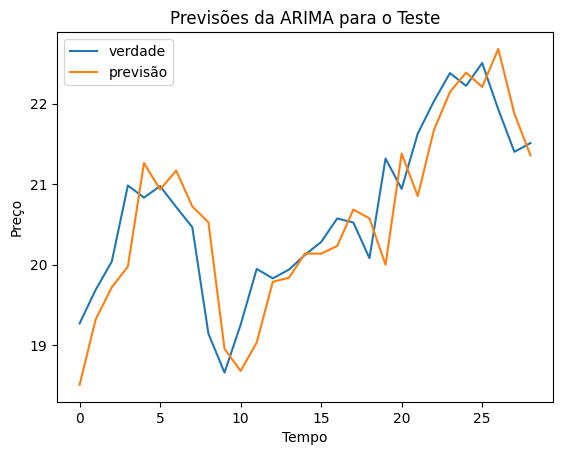

In [505]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

MSE_ARIMA = mean_squared_error(test_ARIMA[31:], pred_ARIMA[31:])
MAPE_ARIMA = mean_absolute_percentage_error(test_ARIMA[31:], pred_ARIMA[31:])
print(f'MSE do Teste: {MSE_ARIMA:.3f} RMSE do Teste: {sqrt(MSE_ARIMA):.3f} MAPE do Teste: {MAPE_ARIMA:.3f}')

fig, ax = plt.subplots()
ax.plot(test_ARIMA[31:], label='verdade')
ax.plot(pred_ARIMA[31:], label='previsão')
ax.set(title="Previsões da ARIMA para o Teste",
       xlabel = "Tempo",
       ylabel = "Preço")
ax.legend()

In [506]:
!pip install torchmetrics

In [507]:
X, y = organize_indicators_ma(PETR4SA_df)

In [508]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, test_ind)))
test_dataset = Subset(dataset, list(range(test_ind, len(X))))

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE)
data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)
next(iter(train_loader))[0]

tensor([[14.2007, 14.2007, 14.2007, 14.2007, 14.2007],
        [14.2544, 14.2275, 14.2104, 14.2275, 14.2275],
        [13.7028, 14.0526, 14.1181, 14.0526, 14.0526],
        [13.6930, 13.9627, 14.0408, 13.9627, 13.9627],
        [13.7565, 13.9214, 13.9891, 13.9214, 13.9214]])

In [509]:
LAYER_1 = 8
LAYER_2 = 4
# Perceptron de multiplas camadas
class MLP(nn.Module):
  def __init__(self, input_size):
    super(MLP, self).__init__()
    self.input = input_size
    self.fc1 = nn.Linear(input_size, self.input * LAYER_1)
    self.fc2 = nn.Linear(self.input * LAYER_1, self.input * LAYER_2)
    self.fc3 = nn.Linear(self.input * LAYER_2, self.input * LAYER_2)
    self.fc4 = nn.Linear(self.input * LAYER_2, 1)
    self.dropout = nn.Dropout(p=0.2)
  def forward(self, x):
    x = x.view(-1, self.input)
    x = torch.relu(self.fc1(x))
    x = x + (0.1**0.5)*torch.randn(self.input * LAYER_1)
    #x = self.dropout(x)
    x = torch.relu(self.fc2(x))
    #x = self.dropout(x)
    x = torch.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [511]:
from torchmetrics import MeanAbsolutePercentageError

torch.manual_seed(144)

model_mlp = MLP(len(X[0])).to(device)
loss_fn = nn.MSELoss()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr = 0.001)

In [512]:
# Treinamento / validacao da MLP
N_EPOCHS = 1000
train_losses, valid_losses = [], []
best_epoch = 0
for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model_mlp.train()
  for X_batch, y_batch in train_loader:
    optimizer_mlp.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model_mlp(X_batch)
    loss = loss_fn(y_pred.flatten(), y_batch.flatten())
    loss.backward()
    optimizer_mlp.step()
    running_loss_train += loss.item() * X_batch.size(0)
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)
  with torch.no_grad():
    model_mlp.eval()
    for X_val, y_val in valid_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred = model_mlp(X_val)
      loss = loss_fn(y_val, y_pred)
      running_loss_valid += loss.item() * X_val.size(0)
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(model_mlp.state_dict(), './best_mlp.pth')
    valid_losses.append(epoch_loss_valid)
  if (epoch+1) % 50 == 0:
    print(f"[{(epoch+1)}] Loss do treino: {epoch_loss_train:.4f} Loss da validação: {epoch_loss_valid:.4f}")
    print(f"Menor loss na epoca: {best_epoch}")

[50] Loss do treino: 1.1055 Loss da validação: 1.9274
Menor loss na epoca: 46
[100] Loss do treino: 0.8178 Loss da validação: 1.3268
Menor loss na epoca: 98
[150] Loss do treino: 0.6218 Loss da validação: 0.6300
Menor loss na epoca: 149
[200] Loss do treino: 0.4400 Loss da validação: 0.4143
Menor loss na epoca: 195
[250] Loss do treino: 0.5886 Loss da validação: 0.6179
Menor loss na epoca: 195
[300] Loss do treino: 0.5872 Loss da validação: 0.7750
Menor loss na epoca: 195
[350] Loss do treino: 0.6395 Loss da validação: 0.5256
Menor loss na epoca: 195
[400] Loss do treino: 0.6303 Loss da validação: 0.7398
Menor loss na epoca: 379
[450] Loss do treino: 0.5325 Loss da validação: 0.7576
Menor loss na epoca: 379
[500] Loss do treino: 0.5511 Loss da validação: 0.3720
Menor loss na epoca: 379
[550] Loss do treino: 0.5360 Loss da validação: 0.5824
Menor loss na epoca: 379
[600] Loss do treino: 0.5916 Loss da validação: 0.6428
Menor loss na epoca: 379
[650] Loss do treino: 0.5828 Loss da valida

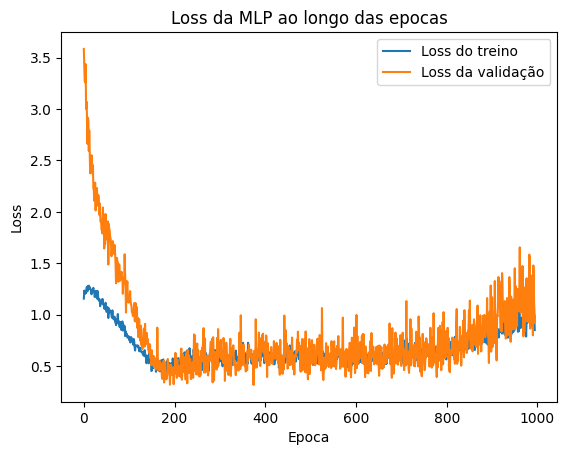

In [513]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
fig, ax = plt.subplots()
ax.plot(train_losses[5:], label='Loss do treino')
ax.plot(valid_losses[5:], label='Loss da validação')
ax.set(title="Loss da MLP ao longo das epocas",
       xlabel = "Epoca",
       ylabel = "Loss")
ax.legend()

In [514]:
state_dict = torch.load('best_mlp.pth')
model_mlp.load_state_dict(state_dict)

<All keys matched successfully>

In [515]:
y_pred_mlp, y_test_mlp = [], []
with torch.no_grad():
  model_mlp.eval()
  for X_val, y_val in test_loader:
    X_val = X_val.to(device)
    y_pred_mlp.append(model_mlp(X_val))
    y_test_mlp.append(y_val)
y_pred_mlp = torch.cat(y_pred_mlp).numpy().flatten()
y_test_mlp = torch.cat(y_test_mlp).numpy().flatten()

MSE: 0.220; RMSE: 0.469; MAPE: 0.018


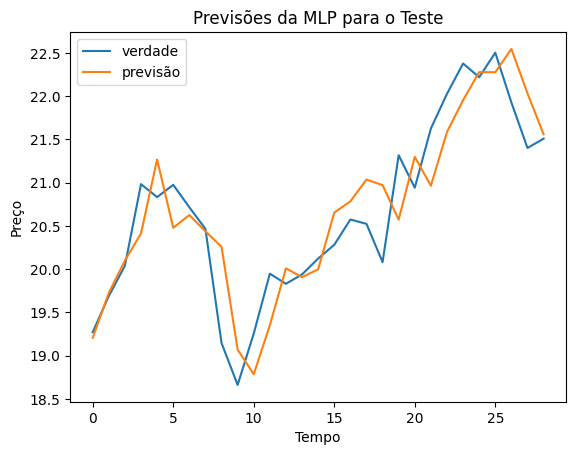

In [516]:
mlp_mse = mean_squared_error(y_test_mlp, y_pred_mlp)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mape = mean_absolute_percentage_error(y_test_mlp, y_pred_mlp)
print(f"MSE: {mlp_mse:.3f}; RMSE: {mlp_rmse:.3f}; MAPE: {mlp_mape:.3f}")

fix, ax = plt.subplots()

ax.plot(y_test_mlp, label='verdade')
ax.plot(y_pred_mlp, label='previsão')

ax.set(title='Previsões da MLP para o Teste',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [517]:
y_pred_mlp_full, y_test_mlp_full = [], []
with torch.no_grad():
  model_mlp.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_mlp_full.append(model_mlp(X_val))
    y_test_mlp_full.append(y_val)
y_pred_mlp_full = torch.cat(y_pred_mlp_full).numpy().flatten()
y_test_mlp_full = torch.cat(y_test_mlp_full).numpy().flatten()

MSE: 0.672; RMSE: 0.820; MAPE: 0.038


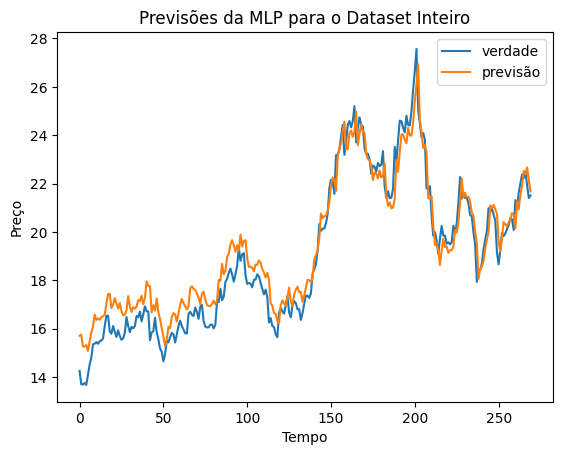

In [518]:
mlp_mse_full = mean_squared_error(y_test_mlp_full, y_pred_mlp_full)
mlp_rmse_full = np.sqrt(mlp_mse_full)
mlp_mape_full = mean_absolute_percentage_error(y_test_mlp_full, y_pred_mlp_full)
print(f"MSE: {mlp_mse_full:.3f}; RMSE: {mlp_rmse_full:.3f}; MAPE: {mlp_mape_full:.3f}")

fix, ax = plt.subplots()

ax.plot(y_test_mlp_full, label='verdade')
ax.plot(y_pred_mlp_full, label='previsão')

ax.set(title='Previsões da MLP para o Dataset Inteiro',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [519]:
VALE3SA = 'VALE3.SA'

VALE3SA_df = yf.download(VALE3SA,
                 start = START_DATE,
                 end = END_DATE,
                 progress = False)

VALE3_prices = VALE3SA_df['Adj Close'].values
VALE3SA_df = add_metrics(VALE3SA_df)

(array([-30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
        -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
         -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
          9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
         22,  23,  24,  25,  26,  27,  28,  29,  30]),
 array([0.86319929, 0.86671178, 0.87039885, 0.87409571, 0.87790492,
        0.88186345, 0.88568037, 0.88945349, 0.8931373 , 0.89671387,
        0.89985453, 0.90302487, 0.90636506, 0.90988218, 0.9133431 ,
        0.91685268, 0.92044615, 0.92412427, 0.92795587, 0.93169429,
        0.93521274, 0.93901128, 0.94269389, 0.94668836, 0.95073923,
        0.95483414, 0.95896617, 0.96306404, 0.96699013, 0.97080166,
        0.97467958, 0.9710085 , 0.96726658, 0.96349785, 0.95984381,
        0.95620769, 0.95260701, 0.94899206, 0.94533903, 0.94161232,
        0.9378797 , 0.93418625, 0.93037283, 0.92653157, 0.92274772,
        0.91891133, 0.91512791, 0.9112414

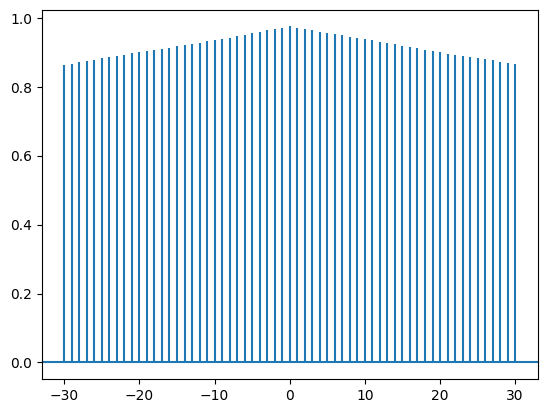

In [520]:
plt.xcorr(PETR4_prices, VALE3_prices, maxlags = 30)

In [521]:
X, y = organize_indicators_ma(VALE3SA_df)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)
next(iter(test_loader))[0]

tensor([[18.6944, 19.6843, 19.3710, 20.2523, 20.1861],
        [19.2708, 19.4696, 19.3528, 20.0381, 20.1718],
        [19.6885, 19.3209, 19.4138, 19.9176, 20.1813],
        [20.0393, 19.2549, 19.5275, 19.8030, 20.2032],
        [20.9832, 19.2892, 19.7922, 19.7732, 20.2378]])

In [522]:
y_pred_mlp_full_VALE, y_test_mlp_full_VALE = [], []
with torch.no_grad():
  model_mlp.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_mlp_full_VALE.append(model_mlp(X_val))
    y_test_mlp_full_VALE.append(y_val)
y_pred_mlp_full_VALE = torch.cat(y_pred_mlp_full_VALE).numpy().flatten()
y_test_mlp_full_VALE = torch.cat(y_test_mlp_full_VALE).numpy().flatten()

MSE: 88.337; RMSE: 9.399; MAPE: 0.119


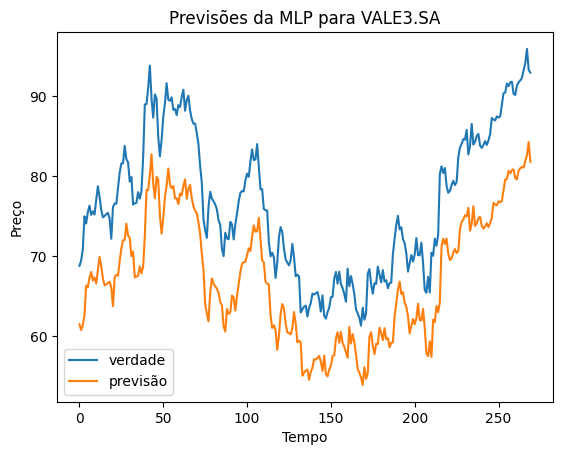

In [523]:
mlp_mse_full_VALE = mean_squared_error(y_test_mlp_full_VALE, y_pred_mlp_full_VALE)
mlp_rmse_full_VALE = np.sqrt(mlp_mse_full_VALE)
mlp_mape_full_VALE = mean_absolute_percentage_error(y_test_mlp_full_VALE, y_pred_mlp_full_VALE)
print(f"MSE: {mlp_mse_full_VALE:.3f}; RMSE: {mlp_rmse_full_VALE:.3f}; MAPE: {mlp_mape_full_VALE:.3f}")

fix, ax = plt.subplots()

ax.plot(y_test_mlp_full_VALE, label='verdade')
ax.plot(y_pred_mlp_full_VALE, label='previsão')

ax.set(title='Previsões da MLP para VALE3.SA',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [573]:
LAYER_1 = 25
class LSTM(nn.Module):
  def __init__(self, input_size):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, input_size * LAYER_1, 1, batch_first=True)
    self.dropout = nn.Dropout(p=0.3)
    self.lstm_2 = nn.LSTM(input_size * LAYER_1, input_size * LAYER_1, 1, batch_first=True)
    self.fc1 = nn.Linear(input_size * LAYER_1, 1)
  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.dropout(x)
    x, _ = self.lstm_2(x)
    x = self.dropout(x)
    x, _ = self.lstm_2(x)
    x = self.dropout(x)
    x = self.fc1(x[:,-1,:])
    return x

In [574]:
# Preparar os dados para a LSTM
X, y = organize_indicators_all(PETR4SA_df)

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], X.shape[1], 1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, test_ind)))
test_dataset = Subset(dataset, list(range(test_ind, len(X))))

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE)
data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)

In [575]:
# Preparar a LSTM

torch.manual_seed(142)

model_lstm = LSTM(1).to(device)
loss_fn = MeanAbsolutePercentageError()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr = 0.001)

In [576]:
# Treino da LSTM
N_EPOCHS = 1000
train_losses, valid_losses = [], []
best_epoch = 0
# Treinamento / validacao
for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model_lstm.train()
  for X_batch, y_batch in train_loader:
    optimizer_lstm.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model_lstm(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer_lstm.step()
    running_loss_train += loss.item() * X_batch.size(0)
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)
  with torch.no_grad():
    model_lstm.eval()
    for X_val, y_val in valid_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred = model_lstm(X_val)
      loss = loss_fn(y_val, y_pred)
      running_loss_valid += loss.item() * X_val.size(0)
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(model_lstm.state_dict(), './best_lstm.pth')
    valid_losses.append(epoch_loss_valid)
  if (epoch+1) % 50 == 0:
    print(f"[{(epoch+1)}] Loss do treino: {epoch_loss_train:.5f} Loss da validação: {epoch_loss_valid:.5f}")
    print(f"Menor loss na epoca: {best_epoch}")

[50] Loss do treino: 0.17037 Loss da validação: 0.15860
Menor loss na epoca: 28
[100] Loss do treino: 0.16840 Loss da validação: 0.15825
Menor loss na epoca: 56
[150] Loss do treino: 0.16774 Loss da validação: 0.14910
Menor loss na epoca: 107
[200] Loss do treino: 0.16762 Loss da validação: 0.14801
Menor loss na epoca: 107
[250] Loss do treino: 0.17093 Loss da validação: 0.14739
Menor loss na epoca: 107
[300] Loss do treino: 0.16232 Loss da validação: 0.14009
Menor loss na epoca: 292
[350] Loss do treino: 0.10845 Loss da validação: 0.06309
Menor loss na epoca: 325
[400] Loss do treino: 0.10533 Loss da validação: 0.12068
Menor loss na epoca: 325
[450] Loss do treino: 0.10934 Loss da validação: 0.08094
Menor loss na epoca: 325
[500] Loss do treino: 0.10008 Loss da validação: 0.06644
Menor loss na epoca: 325
[550] Loss do treino: 0.09468 Loss da validação: 0.05542
Menor loss na epoca: 325
[600] Loss do treino: 0.08320 Loss da validação: 0.05866
Menor loss na epoca: 561
[650] Loss do trein

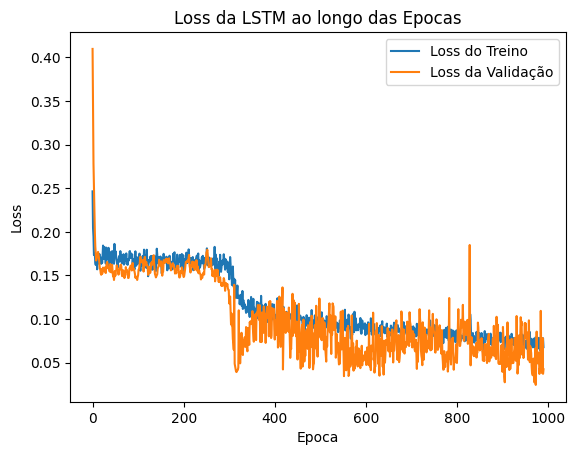

In [577]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
fig, ax = plt.subplots()
# Inicio em 9 para não mostrar o ruido inicial
ax.plot(train_losses[9:], label='Loss do Treino')
ax.plot(valid_losses[9:], label='Loss da Validação')
ax.set(title="Loss da LSTM ao longo das Epocas",
       xlabel = "Epoca",
       ylabel = "Loss")
ax.legend()

In [578]:
state_dict = torch.load('best_lstm.pth')
model_lstm.load_state_dict(state_dict)

<All keys matched successfully>

In [579]:
y_pred_lstm, y_test_lstm = [], []
with torch.no_grad():
  model_lstm.eval()
  for X_val, y_val in test_loader:
    X_val = X_val.to(device)
    y_pred_lstm.append(model_lstm(X_val))
    y_test_lstm.append(y_val)
y_pred_lstm = torch.cat(y_pred_lstm).numpy().flatten()
y_test_lstm = torch.cat(y_test_lstm).numpy().flatten()

MSE: 1.6468; RMSE: 1.2833; MAPE: 0.0560


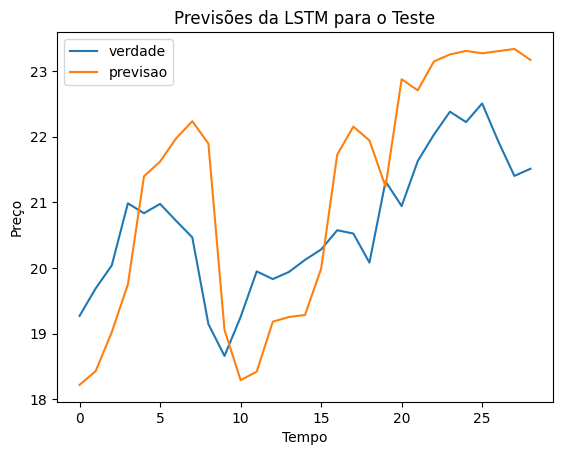

In [580]:
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_lstm, y_pred_lstm)
print(f"MSE: {lstm_mse:.4f}; RMSE: {lstm_rmse:.4f}; MAPE: {lstm_mape:.4f}")

fix, ax = plt.subplots()

ax.plot(y_test_lstm, label='verdade')
ax.plot(y_pred_lstm, label='previsao')

ax.set(title='Previsões da LSTM para o Teste',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [581]:
y_pred_lstm_full, y_test_lstm_full = [], []
with torch.no_grad():
  model_lstm.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_lstm_full.append(model_lstm(X_val))
    y_test_lstm_full.append(y_val)
y_pred_lstm_full = torch.cat(y_pred_lstm_full).numpy().flatten()
y_test_lstm_full = torch.cat(y_test_lstm_full).numpy().flatten()

MSE: 0.6927; RMSE: 0.8323; MAPE: 0.0315


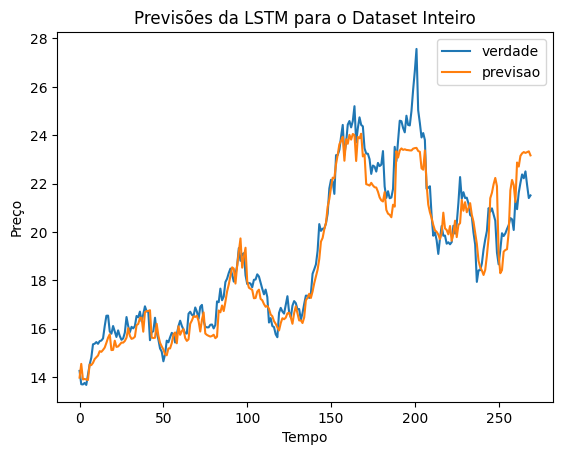

In [582]:
lstm_mse_full = mean_squared_error(y_test_lstm_full, y_pred_lstm_full)
lstm_rmse_full = np.sqrt(lstm_mse_full)
lstm_mape_full = mean_absolute_percentage_error(y_test_lstm_full, y_pred_lstm_full)
print(f"MSE: {lstm_mse_full:.4f}; RMSE: {lstm_rmse_full:.4f}; MAPE: {lstm_mape_full:.4f}")

fix, ax = plt.subplots()

ax.plot(y_test_lstm_full, label='verdade')
ax.plot(y_pred_lstm_full, label='previsao')

ax.set(title='Previsões da LSTM para o Dataset Inteiro',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [583]:
X, y = organize_indicators_all(VALE3SA_df)

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], X.shape[1], 1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)

In [584]:
y_pred_lstm_full_VALE, y_test_lstm_full_VALE = [], []
with torch.no_grad():
  model_lstm.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_lstm_full_VALE.append(model_lstm(X_val))
    y_test_lstm_full_VALE.append(y_val)
y_pred_lstm_full_VALE = torch.cat(y_pred_lstm_full_VALE).numpy().flatten()
y_test_lstm_full_VALE = torch.cat(y_test_lstm_full_VALE).numpy().flatten()

MSE: 3039.1848; RMSE: 55.1288; MAPE: 0.7082


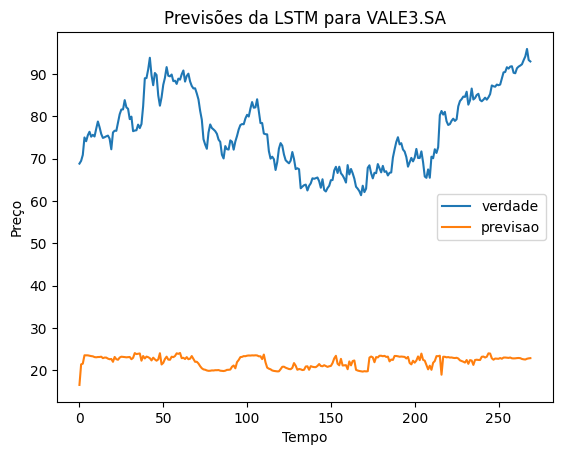

In [585]:
lstm_mse_full_VALE = mean_squared_error(y_test_lstm_full_VALE, y_pred_lstm_full_VALE)
lstm_rmse_full_VALE = np.sqrt(lstm_mse_full_VALE)
lstm_mape_full_VALE = mean_absolute_percentage_error(y_test_lstm_full_VALE, y_pred_lstm_full_VALE)
print(f"MSE: {lstm_mse_full_VALE:.4f}; RMSE: {lstm_rmse_full_VALE:.4f}; MAPE: {lstm_mape_full_VALE:.4f}")

fix, ax = plt.subplots()

ax.plot(y_test_lstm_full_VALE, label='verdade')
ax.plot(y_pred_lstm_full_VALE, label='previsao')

ax.set(title='Previsões da LSTM para VALE3.SA',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

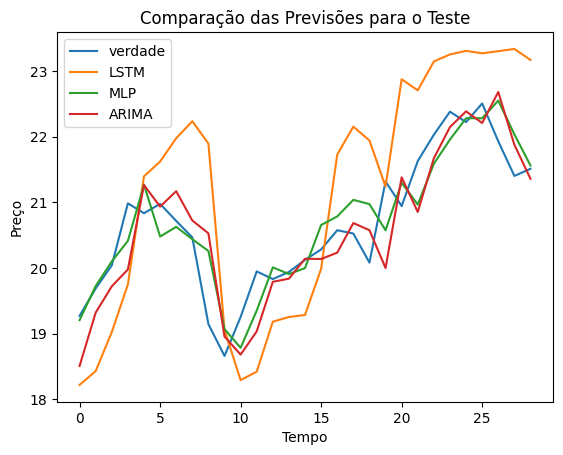

In [586]:
fix, ax = plt.subplots()

ax.plot(y_test_lstm, label='verdade')
ax.plot(y_pred_lstm, label='LSTM')
ax.plot(y_pred_mlp, label='MLP')
ax.plot(pred_ARIMA[31:], label='ARIMA')

ax.set(title='Comparação das Previsões para o Teste',
       xlabel='Tempo',
       ylabel='Preço')
ax.legend()

In [587]:
from tabulate import tabulate

table_test = [['Modelo', 'MSE', 'RMSE', "MAPE"],
         ['ARIMA', MSE_ARIMA, sqrt(MSE_ARIMA), MAPE_ARIMA],
         ['ANN', mlp_mse, sqrt(mlp_mse), mlp_mape],
         ['LSTM', lstm_mse, sqrt(lstm_mse), lstm_mape]
]
print("Comparações para o Conjunto de Teste")
print(tabulate(table_test, headers='firstrow', tablefmt='fancy_grid'))

table_vale = [['Modelo', 'MSE', 'RMSE', "MAPE"],
         ['ANN', mlp_mse_full_VALE, sqrt(mlp_mse_full_VALE), mlp_mape_full_VALE],
         ['LSTM', lstm_mse_full_VALE, sqrt(lstm_mse_full_VALE), lstm_mape_full_VALE]
]
print("Comparações para o Conjunto da Vale")
print(tabulate(table_vale, headers='firstrow', tablefmt='fancy_grid'))

Comparações para o Conjunto de Teste
╒══════════╤══════════╤══════════╤═══════════╕
│ Modelo   │      MSE │     RMSE │      MAPE │
╞══════════╪══════════╪══════════╪═══════════╡
│ ARIMA    │ 0.327631 │ 0.57239  │ 0.0219345 │
├──────────┼──────────┼──────────┼───────────┤
│ ANN      │ 0.220129 │ 0.469179 │ 0.0182466 │
├──────────┼──────────┼──────────┼───────────┤
│ LSTM     │ 1.64679  │ 1.28327  │ 0.0559542 │
╘══════════╧══════════╧══════════╧═══════════╛
Comparações para o Conjunto da Vale
╒══════════╤═══════════╤══════════╤══════════╕
│ Modelo   │       MSE │     RMSE │     MAPE │
╞══════════╪═══════════╪══════════╪══════════╡
│ ANN      │   88.3368 │  9.39876 │ 0.119283 │
├──────────┼───────────┼──────────┼──────────┤
│ LSTM     │ 3039.18   │ 55.1288  │ 0.708229 │
╘══════════╧═══════════╧══════════╧══════════╛
